# Which modality predicts time to diagnosis best?

In [1]:
import numpy as np
import pandas as pd

import seaborn as sns
import pylab as plt

from scipy import stats
from statannot import add_stat_annotation
import joblib
from functools import reduce
#import pingouin as pg

from importlib import reload
import sys
import os
sys.path.insert(1,'../')
import plots

In [2]:
reload(plots)
image_path = plots.set_dir()
colors = plots.set_colors()
data_path = '/scratch/c.c21013066/data/ukbiobank/analyses/survival/prodromal/noOsteo/'

In [7]:
fnames = ['intercept','genetics+family','lifestyle_nofam','blood','prodromalsigns_beforeacc','all_acc_features',
         'all_acc_features+blood+lifestyle+genetics+prodromalsigns_beforeacc']
names = ['no-skill','genetics+family','lifestyle','blood','prodromal signs','all accelerometer','combined']
metric = 'auprc'
models = ['diag_ProdHC','diag_ProdallHC','diag_ProdPopulationNoPD']
control_names = ['matched unaffected','unaffected','population']
aucss = []
meanss = []
mean = pd.DataFrame(index=fnames,columns=pd.MultiIndex.from_product([control_names,['mean','ste','std']],
                                                                    names=['control group','statistic']))
for diag,group in zip(models,control_names):
    aucs = []
    means = pd.DataFrame(index=fnames)
    for fi,fname in enumerate(fnames):
        # for population based model
        if diag == 'diag_ProdPopulationNoPD':
            cph_aucs = pd.read_csv(f'{data_path}/{fname}/{diag}_allHC/rsf_{metric}s_5cv.csv')
            means['control'] = group
        elif diag == 'diag_ProdHC':
            # for HC as controls
            cph_aucs = pd.read_csv(f'{data_path}{fname}/_matchedrsf_{metric}s_5cv.csv')
            means['control'] = group
        elif diag == 'diag_ProdallHC':
            cph_aucs = pd.read_csv(f'{data_path}{fname}/_allHCrsf_{metric}s_5cv.csv')
            means['control'] = group
        auc = cph_aucs.iloc[:,2:].unstack().reset_index()
        auc['modality'] = fname
        auc['level_0'] = auc['level_0'].astype(float)
        aucs.append(auc)
        means.loc[fname,'mean'] = cph_aucs['mean'].mean()
        means.loc[fname,'std'] = cph_aucs['mean'].std()
        means.loc[fname,'ste'] = (cph_aucs['mean'].std())/np.sqrt(5)
        mean.loc[fname,(group,'mean')] = means.loc[fname,'mean']
        mean.loc[fname,(group,'ste')] = means.loc[fname,'ste']
        mean.loc[fname,(group,'std')] = means.loc[fname,'std']
    #means.to_csv(f'/scratch/c.c21013066/data/ukbiobank/analyses/survival/prodromal/noOsteo/means_{diag}.csv')
    aucs = pd.concat(aucs)
    aucss.append(aucs)
    #means = means.reset_index().set_index(['index','control']).unstack().swaplevel(0,1,axis=1)
    meanss.append(means)

In [5]:
mean.to_csv(f'/scratch/c.c21013066/data/ukbiobank/analyses/survival/prodromal/noOsteo/means.csv')

In [7]:
#pvalues
#features = np.hstack([stacked_features_names,features])
models = ['diag_ProdHC','diag_ProdallHC','diag_ProdPopulationNoPD']
control_names = ['matched unaffected','unaffected','population']
statistics = pd.DataFrame(columns=pd.MultiIndex.from_product([control_names,['T','dof','alternative','p-value','CI95%',
                                                               'cohen-d','BF10','power']],names=['model','statistic']),
                       index=pd.MultiIndex.from_product([names,names],names=['modality1','modality2']))
pvalues = pd.DataFrame(columns=pd.MultiIndex.from_product([control_names,['T','dof','alternative','p-value','CI95%',
                                                               'cohen-d','BF10','power']],names=['model','statistic']),
                       index=pd.MultiIndex.from_product([names,names],names=['modality1','modality2']))

for (i,f1name),f1 in zip(enumerate(names),fnames):
    for (j,f2name),f2 in zip(enumerate(names),fnames):
        if j>i:
            for c,model in enumerate(control_names):
                auc = aucss[c]
                statistics.loc[(f1name,f2name),(model,slice(None))] = pg.ttest(auc.loc[auc['modality']==f1,0],
                                   auc.loc[auc['modality']==f2,0]).values
                t,p = stats.ttest_ind(auc.loc[auc['modality']==f1,0],
                                   auc.loc[auc['modality']==f2,0])
                pvalues.loc[(f1name,f2name),(model,'p-value')] = p
                pvalues.loc[(f1name,f2name),(model,'T')] = t
pvalues = pvalues.dropna(axis='rows',how='all')
statistics = statistics.dropna(axis='rows',how='all')
# get pvalues that are significant
keep = pvalues.loc[:,(slice(None),'p-value')]<(0.05/pvalues.shape[0])
pvalues_sig = pvalues[keep]
# extract boxpairs from that
box_pairs = []
for model in control_names:
    sig = pvalues_sig[model].dropna(axis='rows',how='all',subset=['p-value'])
    for key,s in sig.iterrows():
        box_pairs.append(((model,key[0]),(model,key[1])))

/scratch/c.c21013066/docker/envs/pythonstats/lib/python3.9/site-packages/pingouin/parametric.py:261: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  tval, pval = ttest_ind(x, y, equal_var=True, alternative=alternative)
/tmp/ipykernel_63074/3552056889.py:19: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  t,p = stats.ttest_ind(auc.loc[auc['modality']==f1,0],
/scratch/c.c21013066/docker/envs/pythonstats/lib/python3.9/site-packages/pingouin/parametric.py:261: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  tval, pval = ttest_ind(x, y, equal_var=True, alternative=alternative)
/tmp/ipykernel_63074/3552056889.py:19: Runtime

In [8]:
statistics.to_csv('/scratch/c.c21013066/data/ukbiobank/analyses/survival/prodromal/noOsteo/pvaluesAUROC.csv')

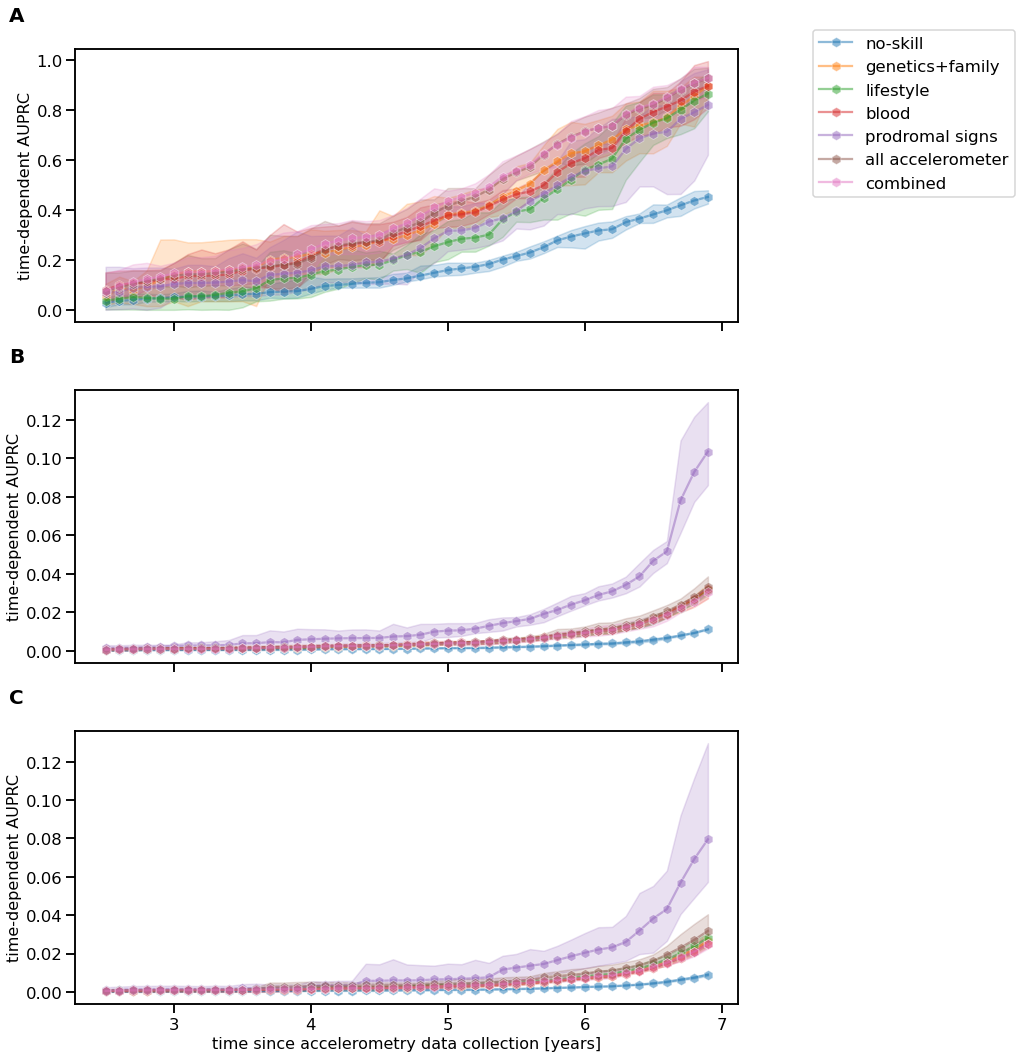

In [5]:
fig,axes = plt.subplots(ncols=1,nrows=3,figsize=(15,15),sharex=True)
plots.plot_context()
plotlabels = ['A','B','C']
for ax,aucs,means,plotlabel in zip(axes.flatten(),aucss,meanss,plotlabels):
    ax = sns.lineplot(x='level_0',y=0,data=aucs,hue='modality',ax=ax,alpha=0.5,ci=(100 - 0.05/len(names)),marker='h',markersize=10)
    if plotlabel=='C':
        ax.set_xlabel('time since accelerometry data collection [years]')
    else:
        ax.set_xlabel('')
    ax.set_ylabel(f'time-dependent {metric.upper()}')
    #ax.set_ylim([0,1])
    ax.text(-0.1, 1.1,plotlabel, transform=ax.transAxes, 
            size=20, weight='bold')
    labels = []
    for fi,fname in enumerate(fnames):
        mean = means.loc[fname,'mean']
        ste = means.loc[fname,'ste']
        labels.append(f'{names[fi]}')#': {mean:.2f} ({ste:.2f})')
    if plotlabel=='A':
        ax.legend(labels=labels,bbox_to_anchor=(1.1,1.1))
    else:
        ax.legend([],[],frameon=False)
plt.tight_layout()
plt.savefig(f'{image_path}/rsf_5cv_{metric.upper()}time_modalities_HCpop.pdf',bbox_inches='tight',dpi=300)
plt.savefig(f'{image_path}/rsf_5cv_{metric.upper()}time_modalities_HCpop.png',bbox_inches='tight',dpi=300)

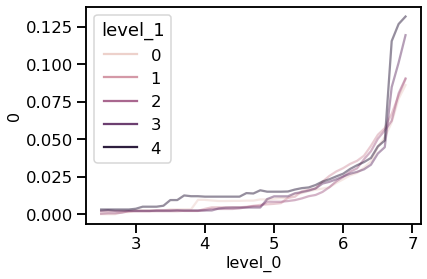

In [16]:
data = aucss[1]
data = data[data['modality']=='prodromalsigns_beforeacc']
sns.lineplot(x='level_0',y=0,data=data,ci=(100 - 0.05/len(names)),hue='level_1',alpha=0.5)
plt.show()

                                                               control  \
intercept                                           matched unaffected   
genetics+family                                     matched unaffected   
lifestyle_nofam                                     matched unaffected   
blood                                               matched unaffected   
prodromalsigns_beforeacc                            matched unaffected   
all_acc_features                                    matched unaffected   
all_acc_features+blood+lifestyle+genetics+prodr...  matched unaffected   

                                                        mean           std  \
intercept                                           0.500000  5.551115e-17   
genetics+family                                     0.502049  6.574407e-02   
lifestyle_nofam                                     0.459240  1.094211e-01   
blood                                               0.558751  6.072299e-02   
prodromalsigns_be

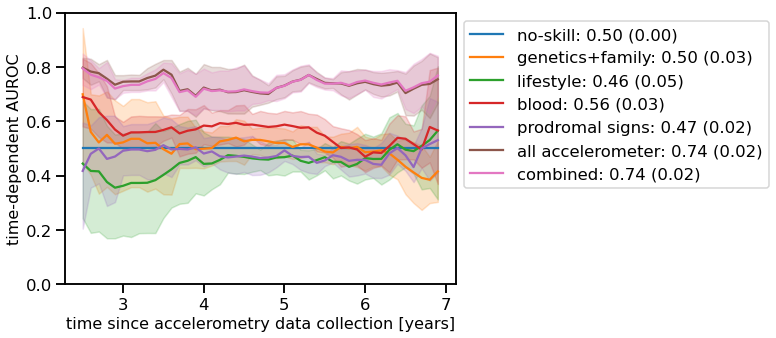

In [44]:
fig = plt.figure(figsize=(7,5))
plots.plot_context()
aucs = aucss[0]
means = meanss[0]
labels = []
print(means)
for fi,fname in enumerate(fnames):
    mean = means.loc[fname,'mean']
    ste = means.loc[fname,'ste']
    labels.append(f'{names[fi]}: {mean:.2f} ({ste:.2f})')
dict_mod = dict(zip(fnames, labels))
aucs['modality'] = aucs['modality'].replace(dict_mod)
ax = sns.lineplot(x='level_0',y=0,data=aucs,ci=95,hue='modality')
ax.set_xlabel('time since accelerometry data collection [years]')
ax.set_ylabel('time-dependent AUROC')
ax.set_ylim([0,1])
#lines, _= ax.get_legend_handles_labels()
ax.legend(bbox_to_anchor=(1,1))
#plt.savefig(f'{image_path}/rsf_5cv_AUCtime_modalities_HC.pdf',bbox_inches='tight',dpi=300)
plt.savefig(f'{image_path}/rsf_5cv_AUCtime_modalities_HC.png',bbox_inches='tight',dpi=300)

## look at specific model and the predictions

In [29]:
#pred = np.load(f'{data_path}/predictors.npy')
df_dummy_test = pd.read_csv(f'{data_path}/all_acc_features/_matchedrsftest_cv0.csv').set_index('eid')
coxnet_pred = joblib.load(f'{data_path}/all_acc_features/_matchedmodelrsf_CV0.joblib')

<frozen importlib._bootstrap>:219: RuntimeWarning: sklearn.tree._splitter.Splitter size changed, may indicate binary incompatibility. Expected 360 from C header, got 1160 from PyObject


In [30]:
prod = pd.read_csv('/scratch/c.c21013066/data/ukbiobank/merged_data/unaffectedNoOsteoAllHC.csv').set_index('eid')
prod = prod[prod['Status']!='Diseased']

In [31]:
for prod_eid in df_dummy_test[df_dummy_test['Status']==True].index:
    # find hc match
    hc_matches_eid = prod.loc[np.logical_and(prod['Status']=='Healthy',
                                      np.logical_and(prod['accelerometry_age'].round()==prod.loc[prod_eid,'accelerometry_age'].round(),
                                                     prod['male']==prod.loc[prod_eid,'male']))].index
    if len(hc_matches_eid)>0:
        for eid in hc_matches_eid:
            try:
                df_dummy_test.loc[eid]
                print('prod',prod_eid)
                print('hc',eid)
                break
            except:
                pass

prod 1085206
hc 2527367
prod 1090225
hc 2449497
prod 1254917
hc 4475960
prod 1316604
hc 1157026
prod 1556714
hc 1157026
prod 1566448
hc 1839583
prod 2103234
hc 1839583
prod 2247026
hc 5324142
prod 2964559
hc 1839583
prod 3082361
hc 3006477
prod 3234121
hc 2078208
prod 3391605
hc 5526259
prod 3532577
hc 1834951
prod 3737494
hc 5526259
prod 4868702
hc 2400041
prod 5032968
hc 1834951
prod 5906685
hc 5526259


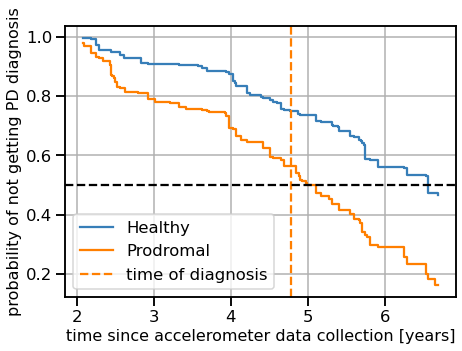

In [38]:
# test on new data
x_new = df_dummy_test.loc[([5526259,5906685])].iloc[:,2:]
pred_surv = coxnet_pred.predict_survival_function(x_new,return_array=True)
time_points = np.arange(2.5, 7,0.1)

fig = plt.figure(figsize=(7,5))
plots.plot_context()
for (i, surv_func),label,color in zip(enumerate(pred_surv),['Healthy','Prodromal'],[colors.healthy,colors.prodromal]):
    plt.step(coxnet_pred.event_times_, surv_func, where="post",
             label=label,color=color)
plt.ylabel("Survival probability")
plt.xlabel("Time in days")
plt.legend()
plt.grid(True)
plt.axvline(df_dummy_test.loc[([5906685]),'Survival_in_years'].values,0,1,ls='--',color=colors.prodromal,label='time of diagnosis')
plt.axhline(y=0.5,xmin=0,xmax=1,ls='--',color='black')
plt.ylabel("probability of not getting PD diagnosis")
plt.xlabel("time since accelerometer data collection [years]")
plt.legend(loc="best");
plt.savefig(f'{image_path}/rsfsurvival_prodhc_timeline.pdf',bbox_inches="tight",dpi=200)
plt.savefig(f'{image_path}/rsfsurvival_prodhc_timeline.png',bbox_inches="tight",dpi=300)

In [44]:
x_new = df_dummy_test.iloc[:,2:]
pred_surv = pd.DataFrame(coxnet_pred.predict_survival_function(x_new,return_array=True),index=x_new.index)
time_points = np.arange(2.5, 7,0.1)

In [54]:
prod = pd.read_csv('/scratch/c.c21013066/data/ukbiobank/merged_data/populationNoOsteoAllHC.csv').set_index('eid')
m = pd.merge(x_new,prod[['Status','diagnosis']],left_index=True,right_index=True,how='left')

In [55]:
merged = pd.merge(m,pred_surv,right_index=True,left_index=True,how='outer')
# get mean for each group
means = merged[~np.logical_and(merged['diagnosis']=='ParkinsonDisease',merged['Status']=='Prodromal')].groupby(['Status'])[pred_surv.columns].mean()
mean_prod = merged[np.logical_and(merged['diagnosis']=='ParkinsonDisease',merged['Status']=='Prodromal')][pred_surv.columns].mean()
means.loc['Prodromal PD',:] = mean_prod

stds = merged[~np.logical_and(merged['diagnosis']=='ParkinsonDisease',merged['Status']=='Prodromal')].groupby(['Status'])[pred_surv.columns].std()
std_prod = merged[np.logical_and(merged['diagnosis']=='ParkinsonDisease',merged['Status']=='Prodromal')][pred_surv.columns].std()
stds.loc['Prodromal PD',:] = std_prod

In [56]:
means

,0,1,2,3,4,5,6,7,8,9,...,80,81,82,83,84,85,86,87,88,89
Status,,,,,,,,,,,,,,,,,,,,,
Healthy,0.996942,0.993818,0.990684,0.984686,0.977725,0.975009,0.972047,0.968985,0.965813,0.962372,...,0.607825,0.604013,0.594326,0.588558,0.583862,0.572183,0.562403,0.544761,0.537988,0.508028
Prodromal PD,0.991657,0.984304,0.975167,0.967014,0.960625,0.953372,0.946692,0.937655,0.931078,0.925871,...,0.483329,0.472287,0.461593,0.446220,0.435377,0.425876,0.408872,0.389176,0.374302,0.361460


In [64]:
means.index = ['Other Diagnosis','Healthy','Other Prodromal','Prodromal PD']
stds.index = ['Other Diagnosis','Healthy','Other Prodromal','Prodromal PD']

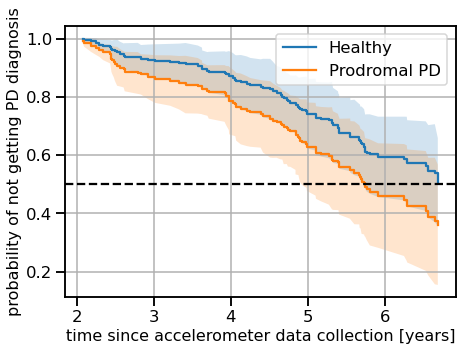

In [57]:
fig = plt.figure(figsize=(7,5))
plots.plot_context()
for key,surv_func in means.iterrows():
    plt.step(coxnet_pred.event_times_, surv_func, where="post",
             label=key)
    plt.fill_between(coxnet_pred.event_times_, surv_func+stds.loc[key],surv_func-stds.loc[key],alpha=0.2)
plt.ylabel("Survival probability")
plt.xlabel("Time in days")
plt.legend()
plt.grid(True)
#plt.axvline(df_dummy_test.loc[([5906685]),'Survival_in_years'].values,0,1,ls='--',color=colors.prodromal)
plt.axhline(y=0.5,xmin=0,xmax=1,ls='--',color='black')
plt.ylabel("probability of not getting PD diagnosis")
plt.xlabel("time since accelerometer data collection [years]")
plt.legend(bbox_to_anchor=(1,1));
plt.savefig(f'{image_path}/rsfKaplanMeyer_allaccelerometry_HC.pdf',bbox_inches="tight",dpi=300)
plt.savefig(f'{image_path}/rsfKaplanMeyer_allaccelerometry_HC.png',bbox_inches="tight",dpi=300)

## Sanity check: how many diagnoses per time interval in test data?

In [27]:
fnames = ['intercept','genetics+family','lifestyle_nofam','blood','prodromalsigns_beforeacc','all_acc_features',
         'all_acc_features+blood+lifestyle+genetics+prodromalsigns_beforePD']
names = ['no-skill','genetics+family','lifestyle','blood','prodromal signs','all accelerometer','combined']
models = ['diag_ProdHC','diag_ProdallHC','diag_ProdPopulationNoPD_allHC']
control_names = ['matched unaffected','unaffected','population']
preds_cv = []
real_cv = []
diag = 'diag_ProdPopulationNoPD_allHC'
for fname in fnames:
    for cv in range(5):
        df_dummy_test = pd.read_csv(f'{data_path}/{fname}/{diag}/rsftest_cv{cv}.csv').set_index('eid')
        survfunc = np.load(f'{data_path}/{fname}/{diag}/rsf_testpred_CV{cv}.csv.npy')
        coxnet_pred = joblib.load(f'{data_path}/{fname}/{diag}/modelrsf_CV{cv}.joblib')
        time_points = coxnet_pred.event_times_
        preds = pd.DataFrame(index=df_dummy_test.index,columns=pd.MultiIndex.from_product([[fname],[cv]],
                                                                                         names = ['modality','cv']))
        real = pd.DataFrame(index=df_dummy_test.index,columns=pd.MultiIndex.from_product([[fname],[cv]],
                                                                                         names = ['modality','cv']))
        for si,subject in enumerate(df_dummy_test.index):
            try:
                index = list(map(lambda i: i < 1-(113/(33009-113)), survfunc[si])).index(True)
                preds.loc[subject,(fname,cv)] = time_points[index]
            except:
                preds.loc[subject,(fname,cv)] = np.nan
            real.loc[subject,(fname,cv)] = df_dummy_test.loc[subject,'Survival_in_years'] if \
                df_dummy_test.loc[subject,'Status'] else np.nan
        preds_cv.append(preds)
        real_cv.append(real)
preds_merged = reduce(lambda left, right: pd.merge(left, right, right_index=True,
                                                   left_index=True,how='outer'), preds_cv).astype(float)
real_merged = reduce(lambda left, right: pd.merge(left, right, right_index=True,
                                                  left_index=True,how='outer'), real_cv).astype(float)
preds_mean = preds_merged.mean(axis=1,level=0)
real_mean = real_merged.mean(axis=1,level=0)
# diagnoses per year
real_counts = real_mean.apply(lambda x: round(x, 0).value_counts()).sort_index()
pred_counts = preds_mean.apply(lambda x: round(x, 0).value_counts()).sort_index()
pred_counts = pred_counts.reindex(np.arange(2,8), fill_value=np.nan)

In [29]:
real_counts = real_counts.iloc[:,0].rename('observed').to_frame()
counts = pd.merge(pred_counts,real_counts,right_index=True,left_index=True)

In [96]:
sys.path.insert(0,'/scratch/c.c21013066/software/scikit-survival/sksurv')
import util

In [66]:
test

,Unnamed: 0,Status,Survival_in_years,y_risk
eid,,,,
1006141,0,False,6.925764,0.327299
1009367,1,False,7.358353,0.181939
1015494,2,False,7.196817,0.031020
1017285,3,False,6.988736,0.324323
1017390,4,False,6.139985,0.295932
...,...,...,...,...
6020907,6619,False,5.877146,0.042708
6021077,6620,False,5.622520,0.096236
6021363,6621,False,5.644423,0.016147


In [91]:
# sort by risk score (descending)
name = 'diag_ProdPopulationNoPD'
fname = 'all_acc_features'
dt=dtype=[('Status', '?'), ('Survival_in_years', '<f8')]
test = pd.read_csv(f'{data_path}/{fname}/{diag}/rsf_testrisk_CV{cv}.csv',index_col=1)
estimate = test['y_risk'].values
survival_test = np.array([tuple(row) for row in test[['Status','Survival_in_years']].values], dtype=dt)
times = np.arange(2.5,7,0.1)
test_event, test_time = util.check_y_survival(survival_test)
o = np.argsort(-estimate)
test_time = test_time[o]
test_event = test_event[o]
estimate = estimate[o]
survival_test = survival_test[o]
tied_tol = 1e-8

cct = pd.DataFrame(columns=['case','control','tp','fp'],index = times)
for k, t in enumerate(times):
    is_case = (test_time <= t) & test_event
    is_control = test_time > t
    n_controls = is_control.sum()
    cct.loc[t,'control'] = n_controls
    cct.loc[t,'case'] = is_case.sum()

    true_pos = []
    false_pos = []
    tp_value = 0.0
    fp_value = 0.0
    est_prev = np.infty

    for i in range(n_samples):
        est = estimate[i]
        if np.absolute(est - est_prev) > tied_tol:
            true_pos.append(tp_value)
            false_pos.append(fp_value)
            est_prev = est
        if is_case[i]:
            tp_value += 1
        elif is_control[i]:
            fp_value += 1
    true_pos.append(tp_value)
    false_pos.append(fp_value)
    cct.loc[t,'tp'] = tp_value
    cct.loc[t,'fp'] = fp_value

In [100]:
n_samples

6624

In [92]:
cct

,case,control,tp,fp
2.5,1,6623,1,6623
2.6,2,6622,2,6622
2.7,3,6621,3,6621
2.8,3,6621,3,6621
2.9,3,6621,3,6621
3.0,3,6621,3,6621
3.1,3,6621,3,6621
3.2,3,6621,3,6621
3.3,3,6621,3,6621
3.4,4,6620,4,6620


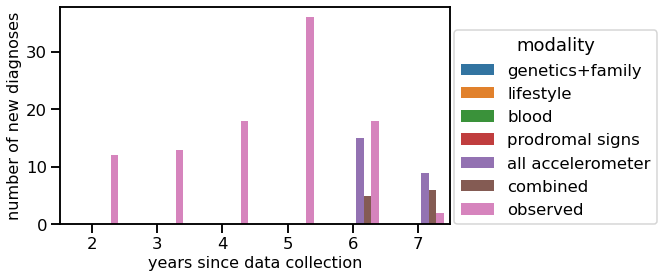

In [286]:
fig = plt.figure(figsize=(7,4))
plots.plot_context()
ax = sns.barplot(data=counts.unstack().reset_index(),x='level_1',y=0,hue='level_0')
ax.set_xlabel('years since data collection')
ax.set_ylabel('number of new diagnoses')
h, l = ax.get_legend_handles_labels()
plt.legend(h,np.hstack([names,'observed']),title='modality',loc=(1.01,0))
#plt.savefig(f'{image_path}/testset_true_diagnosistime.png',dpi=300)
#plt.savefig(f'{image_path}/testset_true_diagnosistime.pdf',dpi=300)

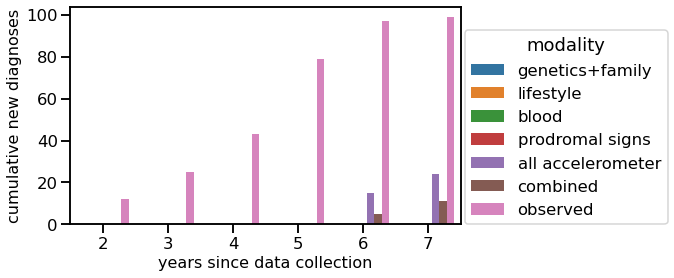

In [287]:
cumcounts = counts.cumsum()
fig = plt.figure(figsize=(7,4))
plots.plot_context()
ax = sns.barplot(data=cumcounts.unstack().reset_index(),x='level_1',y=0,hue='level_0')
ax.set_xlabel('years since data collection')
ax.set_ylabel('cumulative new diagnoses')
h, l = ax.get_legend_handles_labels()
plt.legend(h,np.hstack([names,'observed']),title='modality',loc=(1.01,0))
#plt.savefig(f'{image_path}/testset_true_diagnosistime.png',dpi=300)
#plt.savefig(f'{image_path}/testset_true_diagnosistime.pdf',dpi=300)

In [42]:
33009 - real_counts.observed.values.cumsum()

array([32996, 32981, 32959, 32920, 32900, 32896])

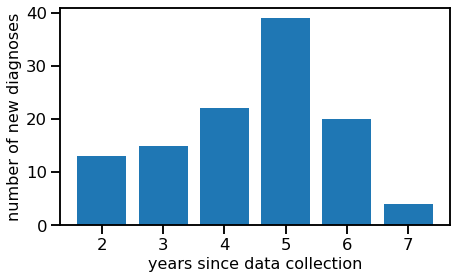

In [38]:
fig = plt.figure(figsize=(7,4))
plots.plot_context()
plt.bar(np.arange(2,8),real_counts.observed.values)
plt.xlabel('years since data collection')
plt.ylabel('number of new diagnoses')
plt.savefig(f'{image_path}/testset_true_diagnosistime.png',dpi=300)
plt.savefig(f'{image_path}/testset_true_diagnosistime.pdf',dpi=300)

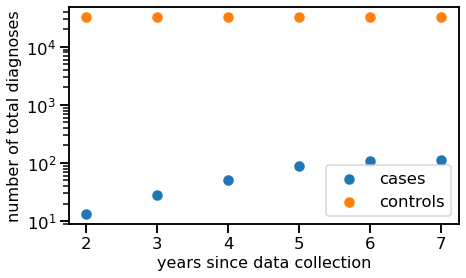

In [50]:
fig = plt.figure(figsize=(7,4))
plots.plot_context()
plt.scatter(np.arange(2,8),real_counts.observed.values.cumsum(),label='cases')
plt.scatter(np.arange(2,8),33009 - real_counts.observed.values.cumsum(),label='controls')
plt.yscale('log')
plt.xlabel('years since data collection')
plt.ylabel('number of total diagnoses')
plt.legend()
#plt.savefig(f'{image_path}/testset_true_diagnosistime.png',dpi=300)
#plt.savefig(f'{image_path}/testset_true_diagnosistime.pdf',dpi=300)

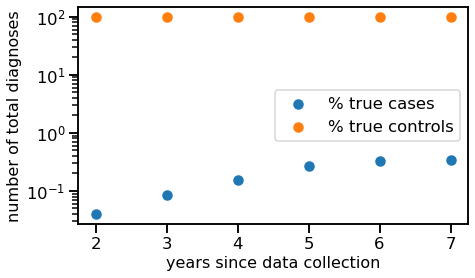

In [56]:
fig = plt.figure(figsize=(7,4))
plots.plot_context()
plt.scatter(np.arange(2,8),100/33009*(real_counts.observed.values.cumsum()),label='% true cases')
plt.scatter(np.arange(2,8),100/33009*(33009 - real_counts.observed.values.cumsum()),label='% true controls')
plt.yscale('log')
plt.xlabel('years since data collection')
plt.ylabel('number of total diagnoses')
plt.legend()

In [55]:
10**2

100